In [1]:
using Plots
using SparseArrays
using Random
using Combinatorics
using LinearAlgebra, Test
using Arpack
using LaTeXStrings
include("unitTests.jl")

testtttt (generic function with 1 method)

In [2]:
# Method to construct 1D Hamiltonian of spinless hardcore bosons with nearest neighbor interactions, hoppings, and onsite potentials h
# N is the number of sites
# J is the interaction energies (size N-1 if pbc=false, otherwise size N). J[j] is the interaction between j, j+1
# t: hoppings at each link, size N-1 if pbc=false, otherwise size N. t[j] is hopping between j and j+1
# computational basis
# pbc= true by default
# need to return list of largest off diagonal elements
# build a sparse Hamiltonian
function construct_disordered_interacting_hamiltonian_nearest_neighbor(N, J, h, t, pbc=true, method="full")
    cols::Vector{Int}=Int[];
    rows::Vector{Int}=Int[];
    values::Vector{Float64}=Float64[];

    # get the off-diagonal terms with the largest coefficient
    max_index = argmax(t)

    if(method=="full")
        H=zeros(Float64, 2^(N), 2^(N));
    end

    off_diags = zeros(Float64, N)

    # need to find all states that correspond to a particular hopping, and also store the largest of-diagonal element
    index_list = [[] for i=1:N]

    # Loop through all the states in the computational basis
    for i=0:2^(N)-1
        # Loop through all the sites
        # Keep track of the digaonal energy terms associated with this particular state 
        energy_of_i = 0
        for j=1:N
            # First we deal with interactions
            # get the occupation at the jth position for the state i
            next_site=0

            # occupation at current site
            occupation=getTi(j-1, i)

            # occupation at the neighboring site
            occupation_next=0
            # get its neighbors occupation. If not PBC and last site, there's no neighbor. If PBC, it's neighbors with the first site
            if(j<N)
                occupation_next=getTi(j, i)
            else
                # if periodic boundary conditions, we get the first site
                if(pbc)
                    occupation_next=getTi(0, i)               
                end
            end

            # the nearest neighbor interaction is the multiplication of the occupations and the interaction strength at link i J[i]
            energy_of_i += J[j]*occupation*occupation_next

            # We add onsite potentials
            energy_of_i += + h[j]*occupation

            # We now deal with hopping
            next_site = 0
            if(!pbc && j==N)
                continue
            end
            # flip the occupation at site j, then i
            if(occupation + occupation_next == 1)
                next_ind = j == N ? 0 : j
                hopping_state = flipBit(next_ind, flipBit(j-1, i))        
                # push the hopping energy to the off-diagonal element
                push!(rows, i+1)
                push!(cols, hopping_state+1)
                push!(values, -t[j]/2)

                push!(rows, hopping_state+1)
                push!(cols, i+1)
                push!(values, -t[j]/2)


                if(i<hopping_state)
                    push!(index_list[j], (i+1, hopping_state+1))
                end
                
                # and the hermitian conjugate
                if(method=="full")
                    H[hopping_state+1, i+1]-=t[j]/2;
                    H[i+1,hopping_state+1]-=t[j]/2;
                end
            end
        end
        push!(rows, i+1);
        push!(cols, i+1);
        push!(values, energy_of_i)
        if(method=="full")
            H[i+1, i+1]=energy_of_i;
        end
    end
    
    if(method=="sparse")
            H=sparse(rows, cols, values);
    end

    return (H, index_list);
end

construct_disordered_interacting_hamiltonian_nearest_neighbor (generic function with 3 methods)

In [3]:
# Method to construct 1D Hamiltonian of spinless hardcore bosons with nearest neighbor interactions, hoppings, and onsite potentials h
# N is the number of sites
# J is the interaction energies (size N-1 if pbc=false, otherwise size N). J[j] is the interaction between j, j+1
# t: hoppings at each link, size N-1 if pbc=false, otherwise size N. t[j] is hopping between j and j+1
# computational basis
# pbc= true by default
# need to return list of largest off diagonal elements
# build a sparse Hamiltonian
function construct_disordered_interacting_hamiltonian_next_nearest_neighbor(N, J, h, t, pbc=true, method="full")
    cols::Vector{Int}=Int[];
    rows::Vector{Int}=Int[];
    values::Vector{Float64}=Float64[];

    # get the off-diagonal terms with the largest coefficient
    max_index = argmax(t)

    if(method=="full")
        H=zeros(Float64, 2^(N), 2^(N));
    end

    off_diags = zeros(Float64, N)

    # need to find all states that correspond to a particular hopping, and also store the largest of-diagonal element
    index_list = [[] for i=1:N]

    # Loop through all the states in the computational basis
    for i=0:2^(N)-1
        # Loop through all the sites
        # Keep track of the digaonal energy terms associated with this particular state 
        energy_of_i = 0
        for j=1:N
            # First we deal with interactions
            # get the occupation at the jth position for the state i
            next_site=0

            # occupation at current site
            occupation=getTi(j-1, i)

            # occupation at the neighboring site
            occupation_next=0
            # get its neighbors occupation. If not PBC and last site, there's no neighbor. If PBC, it's neighbors with the first site

            occupation_next=getTi(j+1 , i)
            if(j+2<=N)
                # note that j is index 1 while getTi takes index 0
                occupation_next=getTi(j+1, i)
            else
                # if periodic boundary conditions, we get the first site
                if(pbc)
                    occupation_next=getTi((j+2)%(N+1) , i)               
                end
            end

            # the nearest neighbor interaction is the multiplication of the occupations and the interaction strength at link i J[i]
            energy_of_i += J[j]*occupation*occupation_next

            # We add onsite potentials
            energy_of_i += + h[j]*occupation

            # We now deal with hopping
            next_site = 0
            if(!pbc && j==N)
                continue
            end

            # occupation at the neighboring site
            occupation_next_hopping=0
            # get its neighbors occupation. If not PBC and last site, there's no neighbor. If PBC, it's neighbors with the first site
            if(j<N)
                occupation_next_hopping=getTi(j, i)
            else
                # if periodic boundary conditions, we get the first site
                if(pbc)
                    occupation_next_hopping=getTi(0, i)               
                end
            end
            
            # flip the occupation at site j, then i
            if(occupation + occupation_next_hopping == 1)
                next_ind = j == N ? 0 : j
                hopping_state = flipBit(next_ind, flipBit(j-1, i))        
                # push the hopping energy to the off-diagonal element
                push!(rows, i+1)
                push!(cols, hopping_state+1)
                push!(values, -t[j]/2)

                push!(rows, hopping_state+1)
                push!(cols, i+1)
                push!(values, -t[j]/2)

                if(i<hopping_state)
                    push!(index_list[j], (i+1, hopping_state+1))
                end
                
                # and the hermitian conjugate
                if(method=="full")
                    H[hopping_state+1, i+1]-=t[j]/2;
                    H[i+1,hopping_state+1]-=t[j]/2;
                end
            end
        end
        push!(rows, i+1);
        push!(cols, i+1);
        push!(values, energy_of_i)
        if(method=="full")
            H[i+1, i+1]=energy_of_i;
        end
    end
    
    if(method=="sparse")
            H=sparse(rows, cols, values);
    end

    return (H, index_list);
end

construct_disordered_interacting_hamiltonian_next_nearest_neighbor (generic function with 3 methods)

In [4]:
function kbits(n::Int, k::Int)
    result = String[]
    for bits in combinations(1:n, k)
        s = fill('0', n)
        for bit in bits
            s[bit] = '1'
        end
        push!(result, join(s))
    end
    return result
end

# 
function construct_map_of_half_filling_states(L)
    temp=sort([parse(Int, x; base=2) for x in kbits(L, div(L, 2))], rev=false)
    dict=Dict{Int, Int}()
    count=1
    for t in temp
        dict[t]=count
        count+=1
    end
    return dict
end

# 
function construct_map_of_n_filling_states(L, n)
    temp=([parse(Int, x; base=2) for x in kbits(L, n)])
    dict=Dict{Int, Int}()
    count=1
    for t in temp
        dict[t]=count
        count+=1
    end
    return dict
end

# Method to construct 1D Hamiltonian of spinless hardcore bosons with nearest neighbor interactions, hoppings, and onsite potentials h
# N is the number of sites
# J is the interaction energies (size N-1 if pbc=false, otherwise size N). J[j] is the interaction between j, j+1
# t: hoppings at each link, size N-1 if pbc=false, otherwise size N. t[j] is hopping between j and j+1
# computational basis
# pbc= true by default
# need to return list of largest off diagonal elements
# build a sparse Hamiltonian
function construct_disordered_interacting_hamiltonian_nearest_neighbor_half_filling(N, J, h, t, map_half_filling_states, pbc=true, method="full")
    cols::Vector{Int}=Int[];
    rows::Vector{Int}=Int[];
    values::Vector{Float64}=Float64[];

    # get the off-diagonal terms with the largest coefficient
    max_index = argmax(t)
    all_states=collect(Base.keys(map_half_filling_states))
    #println(all_states)

    if(method=="full")
        H=zeros(Float64, (length(all_states)), (length(all_states)));
    end

    off_diags = zeros(Float64, N)

    # need to find all states that correspond to a particular hopping, and also store the largest of-diagonal element
    index_list = [[] for i=1:N]

    # Loop through all the computational basis states in the half-filling sector
    for i in all_states
        # Loop through all the sites
        # Keep track of the digaonal energy terms associated with this particular state 
        energy_of_i = 0
        i_index=map_half_filling_states[i]
        for j=1:N
            # First we deal with interactions
            # get the occupation at the jth position for the state i
            next_site=0

            # occupation at current site
            occupation=getTi(j-1, i)

            # occupation at the neighboring site
            occupation_next=0
            # get its neighbors occupation. If not PBC and last site, there's no neighbor. If PBC, it's neighbors with the first site
            if(j<N)
                occupation_next=getTi(j, i)
            else
                # if periodic boundary conditions, we get the first site
                if(pbc)
                    occupation_next=getTi(0, i)               
                end
            end

            # the nearest neighbor interaction is the multiplication of the occupations and the interaction strength at link i J[i]
            energy_of_i += J[j]*occupation*occupation_next

            # We add onsite potentials
            energy_of_i += + h[j]*occupation

            # We now deal with hopping
            next_site = 0

            if(!pbc && j==N)
                continue
            end
            # flip the occupation at site j, then i
            if(occupation + occupation_next == 1)
                # note that j is the next site
                next_ind = j == N ? 0 : j
                hopping_state = flipBit(next_ind, flipBit(j-1, i)) 

                hopping_state_index=map_half_filling_states[hopping_state]
                # push the hopping energy to the off-diagonal element
                push!(rows, i_index)
                push!(cols, hopping_state_index)
                push!(values, -t[j]/2)

                push!(rows, hopping_state_index)
                push!(cols, i_index)
                push!(values, -t[j]/2)

                if(i<hopping_state)
                    push!(index_list[j], (i_index, hopping_state_index))
                end
                
                # and the hermitian conjugate
                if(method=="full")
                    H[hopping_state_index, i_index]-=t[j]/2;
                    H[i_index,hopping_state_index]-=t[j]/2;
                end
            end
        end
        push!(rows, i_index);
        push!(cols, i_index);
        push!(values, energy_of_i)
        if(method=="full")
            H[i_index, i_index]=energy_of_i;
        end
    end
    
    if(method=="sparse")
            H=sparse(rows, cols, values);
    end

    return (H, index_list);
end

construct_disordered_interacting_hamiltonian_nearest_neighbor_half_filling (generic function with 3 methods)

In [5]:
# Method to construct 1D Hamiltonian of spinless hardcore bosons with NEXT nearest neighbor interactions, hoppings, and onsite potentials h
# N is the number of sites
# J is the interaction energies (size N-1 if pbc=false, otherwise size N). J[j] is the interaction between j, j+1
# t: hoppings at each link, size N-1 if pbc=false, otherwise size N. t[j] is hopping between j and j+1
# computational basis
# pbc= true by default
# need to return list of largest off diagonal elements
# build a sparse Hamiltonian
function construct_disordered_interacting_hamiltonian_next_nearest_neighbor_half_filling(N, J, h, t, map_half_filling_states, pbc=true, method="full")
    cols::Vector{Int}=Int[];
    rows::Vector{Int}=Int[];
    values::Vector{Float64}=Float64[];

    # get the off-diagonal terms with the largest coefficient
    max_index = argmax(t)
    all_states=collect(Base.keys(map_half_filling_states))
    #println(all_states)

    if(method=="full")
        H=zeros(Float64, (length(all_states)), (length(all_states)));
    end

    off_diags = zeros(Float64, N)

    # need to find all states that correspond to a particular hopping, and also store the largest of-diagonal element
    index_list = [[] for i=1:N]

    # Loop through all the computational basis states in the half-filling sector
    for i in all_states
        # Loop through all the sites
        # Keep track of the digaonal energy terms associated with this particular state 
        energy_of_i = 0
        i_index=map_half_filling_states[i]
        for j=1:N
            # First we deal with interactions
            # get the occupation at the jth position for the state i
            next_site=0

            # occupation at current site
            occupation=getTi(j-1, i)

            # occupation at the neighboring site
            occupation_next=0
            # get its neighbors occupation. If not PBC and last site, there's no neighbor. If PBC, it's neighbors with the first site

            occupation_next=getTi(j+1 , i)
            if(j+2<=N)
                # note that j is index 1 while getTi takes index 0
                occupation_next=getTi(j+1, i)
            else
                # if periodic boundary conditions, we get the first site
                if(pbc)
                    occupation_next=getTi((j+2)%(N+1) , i)               
                end
            end

            # the nearest neighbor interaction is the multiplication of the occupations and the interaction strength at link i J[i]
            energy_of_i += J[j]*occupation*occupation_next

            # We add onsite potentials
            energy_of_i += + h[j]*occupation

            # We now deal with hopping
            next_site = 0
            if(!pbc && j==N)
                continue
            end

            # occupation at the neighboring site
            occupation_next_hopping=0
            # get its neighbors occupation. If not PBC and last site, there's no neighbor. If PBC, it's neighbors with the first site
            if(j<N)
                occupation_next_hopping=getTi(j, i)
            else
                # if periodic boundary conditions, we get the first site
                if(pbc)
                    occupation_next_hopping=getTi(0, i)               
                end
            end
            
            # flip the occupation at site j, then i
            if(occupation + occupation_next_hopping == 1)
                # note that j is the next site
                next_ind = j == N ? 0 : j
                hopping_state = flipBit(next_ind, flipBit(j-1, i)) 

                hopping_state_index=map_half_filling_states[hopping_state]
                # push the hopping energy to the off-diagonal element
                push!(rows, i_index)
                push!(cols, hopping_state_index)
                push!(values, -t[j]/2)

                push!(rows, hopping_state_index)
                push!(cols, i_index)
                push!(values, -t[j]/2)

                if(i<hopping_state)
                    push!(index_list[j], (i_index, hopping_state_index))
                end
                
                # and the hermitian conjugate
                if(method=="full")
                    H[hopping_state_index, i_index]-=t[j]/2;
                    H[i_index,hopping_state_index]-=t[j]/2;
                end
            end
        end
        push!(rows, i_index);
        push!(cols, i_index);
        push!(values, energy_of_i)
        if(method=="full")
            H[i_index, i_index]=energy_of_i;
        end
    end
    
    if(method=="sparse")
            H=sparse(rows, cols, values);
    end

    return (H, index_list);
end

construct_disordered_interacting_hamiltonian_next_nearest_neighbor_half_filling (generic function with 3 methods)

In [6]:
# number operator at site j, j=1...N
# can rotate back to the original basis to see its structure
function get_number_operator(j, L)
    cols::Vector{Int}=Int[];
    rows::Vector{Int}=Int[];
    values::Vector{Float64}=Float64[];
    for i=0:2^L-1
        occupation=getTi(j-1, i)
        if(occupation==1)
            push!(cols, i+1)
            push!(rows, i+1)
            push!(values, 1)
        end
    end
    return sparse(rows, cols, values)
end

function get_number_operator_dense(j, L)
    N=zeros(Float64, 2^L, 2^L)
    for i=0:2^L-1
        occupation=getTi(j-1, i)
        if(occupation==1)
            N[i+1, i+1] = 1
        end
    end
    return N
end

function get_total_number_operator(L)
    cols::Vector{Int}=Int[];
    rows::Vector{Int}=Int[];
    values::Vector{Float64}=Float64[];
    for i=0:2^L-1
        push!(cols, i+1)
        push!(rows, i+1)
        push!(values, countBits(n))
    end
    return sparse(rows, cols, values)
end

function get_total_number_operator_dense(L)
    N=zeros(Float64, 2^L, 2^L)
    for i=0:2^L-1
        N[i+1, i+1] = countBits(i)
    end
    return N
end

# includes the site at i_0
function get_N_R_operator(L, i_0)
    N=zeros(Float64, 2^L, 2^L)
    for i=0:2^L-1
        N[i+1, i+1] = countBits(i & (2^i_0 - 1))
    end
    return N
end

function get_N_R_operator(L, map, i_0)
    the_values=(collect(keys(map)))
    N=zeros(Float64, length(the_values), length(the_values))
    for i in the_values
        index=map[i]
        N[index, index] = countBits(i & (2^i_0 - 1))
    end
    return N
end

function get_N_L_operator(L, i_0)
    N=zeros(Float64, 2^L, 2^L)
    for i=0:2^L-1
        N[i+1, i+1] = countBits(i & ((2^i_0 - 1) << i_0 ))
    end
    return N
end

function get_N_L_operator(L, map, i_0)
    the_values=(collect(keys(map)))
    N=zeros(Float64, length(the_values), length(the_values))
    for i in the_values
        index=map[i]
        N[index, index] = countBits(i & ((2^i_0 - 1) << i_0 ))
    end
    return N
end

function get_N_R_operator_non_interacting(L, i_0)
    N=zeros(Float64, L, L)
    for i=1:L
        N[i, i] = i<=i_0 ? 1 : 0
    end
    return N
end

function get_N_R_operator_eigenstate_basis(L, eigenstates, i_0)
    N_R=get_N_R_operator(L, i_0)
    N_R=eigenstates'*N_R*eigenstates
    N_R=N_R-Diagonal(diag(N_R))
    return N_R
end

function get_N_R_operator_eigenstate_basis(L, the_map,eigenstates, i_0)
    N_R=get_N_R_operator(L,the_map, i_0)
    N_R=eigenstates'*N_R*eigenstates
    N_R=N_R-Diagonal(diag(N_R))
    return N_R
end


function get_N_R_operator_computational_basis(L, eigenstates, i_0)
        return
end

get_N_R_operator_computational_basis (generic function with 1 method)

# Helpers for quench experiment

In [7]:
# assume the eigenstates are in the computational basis for the half-filling sector
# prepares the state with all particles on the right in the eigenstate basis
function prepare_half_filling_state(eigenstates, map_states, L, i_0)
    # the binary number corresponding to 111...00
    half_filling_binary_no=2^(i_0)-1
    
    # the half filling state but rewritten in the eigenstate basis
    half_filling_state=[]
    index=map_states[half_filling_binary_no]
    for i=1:length(eigenstates[:, 1])
        push!(half_filling_state,eigenstates[index,i])
    end
    return half_filling_state
end

# prepares a state 000...111
function prepare_half_filling_state(eigenstates, map_states, L, i_0)
    # the binary number corresponding to 111...00
    half_filling_binary_no=2^(i_0)-1

    # index 1    
    # the half filling state but rewritten in the eigenstate basis
    half_filling_state=[]
    index=map_states[half_filling_binary_no]
    for i=1:length(eigenstates[:, 1])
        push!(half_filling_state,eigenstates[index,i])
    end
    return half_filling_state
end

# assumes "state" is written in the eigenbasis
# map_states is a map from state -> index. Fine as long as its consistent
function measure_number_particles_right_of_i_0(state, the_map, eigenstates, L, i_0)
    N_R=get_N_R_operator(L,the_map, i_0)
    N_R=eigenstates'*N_R*eigenstates
    return state' * N_R * state
end

function measure_number_particles_left_of_i_0(state, the_map, eigenstates, L, i_0)
    N_R=get_N_L_operator(L,the_map, i_0)
    N_R=eigenstates'*N_R*eigenstates
    return state' * N_R * state
end

measure_number_particles_left_of_i_0 (generic function with 1 method)

# Quench Experiment

In [36]:
# 500 disorder realizations
iterations=1
L= 12; # system size
T = 1 # random hopping strength
t = T*ones(Float64, L); #hopping
#t = ones(L)
W = 10; # disorder strength
the_map=construct_map_of_n_filling_states(L, div(L,2))
d=Uniform(-1,1)
J_mag=0.2
i_0=div(L,2)
J = J_mag*ones(Float64, L); # interactions
all_data=[]
max_time=10000

for i=1:iterations
    h=W*rand(d, L)
    H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_nearest_neighbor_half_filling(L, J, h, t,the_map, false, "full")
    eigtemp=eigen(H_half_filling);
    N_L=get_N_L_operator(L,the_map, i_0)
    N_L=eigtemp.vectors'*N_L*eigtemp.vectors
    particle_number=[]
    the_states=prepare_half_filling_state(eigtemp.vectors, the_map, L, i_0)
    
    for t=0:max_time
        time_evolved=time_evolve_state(the_states, eigtemp.values, t)
        number_particles_left=measure_number_particles_left_of_i_0(time_evolved, the_map,eigtemp.vectors, L, i_0).re
        push!(particle_number, number_particles_left)
    end
    println(particle_number)
    push!(all_data, particle_number) 
end

#save_object("8_11_quench_experiment="*string(W)*", J="*string(J_mag)*", t="*string(T)*".jld2", all_data)

LoadError: InterruptException:

# Testing purposes

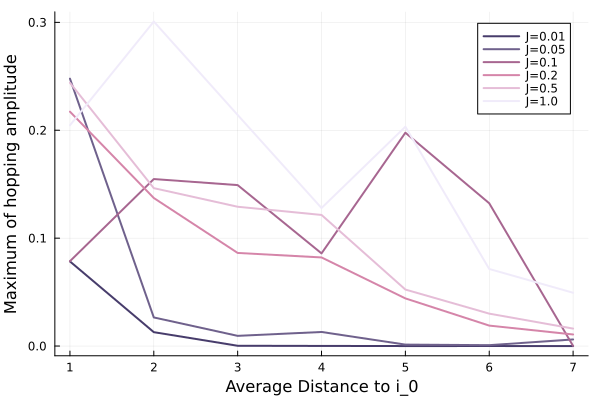

"/Users/jessica/git/Square-Spin-Ice/New code/hopping_amplitude_vs_distance_i_0.png"

In [27]:
include("unitTests.jl")
# 500 disorder realizations
J_mags=[0.01, 0.05, 0.1, 0.2,0.5, 1]

gradient = cgrad(:acton, length(J_mags))  # Use a perceptually uniform colormap


p=plot(linewidth=2, xlabel="Average Distance to i_0", ylabel="Maximum of hopping amplitude")

count=1
for J_mag in J_mags
    iterations=1
    L= 14; # system size
    T = 1 # random hopping strength
    t = T*ones(Float64, L); #hopping
    #t = ones(L)
    W = 10; # disorder strength
    the_map=construct_map_of_n_filling_states(L, div(L,2))
    d=Uniform(-1,1)
    i_0=div(L,2)
    J = J_mag*ones(Float64, L); # interactions
    all_data=[]
    max_time=10

    h=W*rand(d, L)
    H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_nearest_neighbor_half_filling(L, J, h, t,the_map, false, "full")
    eigtemp=eigen(H_half_filling);
    N_L=get_N_L_operator(L,the_map, i_0)
    N_L=eigtemp.vectors'*N_L*eigtemp.vectors
    particle_number=[]
    the_states=prepare_half_filling_state(eigtemp.vectors, the_map, L, i_0)
    
        time_evolved=time_evolve_state(the_states, eigtemp.values, max_time)
        number_particles_left=measure_number_particles_left_of_i_0(time_evolved, the_map,eigtemp.vectors, L, i_0).re
        number_particles_right=measure_number_particles_right_of_i_0(time_evolved, the_map,eigtemp.vectors, L, i_0).re

means=[]
    N_R_no_diag_computational_basis=eigtemp.vectors * get_N_R_operator_eigenstate_basis(L, the_map, eigtemp.vectors, i_0) * eigtemp.vectors'
    the_list=find_hopping_norms_sorted_by_distance_average_from_i0_sector(N_R_no_diag_computational_basis, L, L, div(L,2), the_map, false)
    for i in the_list
        push!(means,maximum(i))
    end
        index = trunc(Int, (count / length(J_mags)) * length(gradient))
plot!(p, 1:div(L,2), means, label="J="*string(J_mag), color=gradient[index],linewidth=2)
    count+=1
end


display(p)
savefig(p, "hopping_amplitude_vs_distance_i_0.png")

In [171]:
include("unitTests.jl")
iterations=1
    L= 5; # system size
    T = 1 # random hopping strength
    t = T*ones(Float64, L); #hopping
    #t = ones(L)
    W = 10; # disorder strength
    the_map=construct_map_of_n_filling_states(L, div(L,2))
    d=Uniform(-1,1)
    i_0=div(L,2)
J_mag=0.1
    J = J_mag*ones(Float64, L); # interactions
    all_data=[]
    max_time=10

    h=W*rand(d, L)

H, max_index_half=construct_disordered_interacting_hamiltonian_next_nearest_neighbor(L, J, h, t, true, "full")
print(h)

[6.584814815302098, 3.186789206873506, -1.2068843227373804, 2.0510773472415345, -5.6137153511181985]

In [170]:
h

4-element Vector{Float64}:
  9.048464868226379
  6.901671199980218
 -1.553885141545981
 -3.740901090619957

In [169]:
H[6,6]

7.694579726680397

In [155]:
function each_configs_with_ones(L::Int, ones::AbstractVector{Int})
    base = zero(UInt)
    @inbounds for i in ones
        base |= UInt(1) << (i-1)
    end
    free = setdiff(1:L, ones)
    n = length(free)
    return collect(begin
        x = base
        @inbounds for k in 1:n
            if (m >> (k-1)) & 0x1 == 1
                x |= UInt(1) << (free[k]-1)
            end
        end
        Int(x)
    end for m in UInt(0):(UInt(1)<<n)-UInt(1))
end

each_configs_with_ones (generic function with 1 method)

In [151]:
function get_interaction_term(sites, H)
    possible_sites=collect(combinations(sites))
    push!(possible_sites,[])
    sum=0
    println(possible_sites)
    for s in possible_sites
        state=0
        for i in s
            state = flipBit(i-1,state)
        end
        sum+=H[state+1, state+1]*(-1)^(length(sites)-length(s))
        #println(H[state+1, state+1]*(-1)^(length(sites)-length(s)))
    end
    return sum
end

get_interaction_term (generic function with 2 methods)

In [145]:
J

4-element Vector{Float64}:
 0.1
 0.1
 0.1
 0.1

In [193]:
include("unitTests.jl")
# 500 disorder realizations
J_mags=[0.05, 0.1, 0.5, 1]

gradient = cgrad(:acton, length(J_mags))  # Use a perceptually uniform colormap


p=plot(linewidth=2, xlabel="Average Distance to i_0", ylabel="Maximum of hopping amplitude")
all_all_data=[]
count=1
L= 12; # system size
for J_mag in J_mags
    all_data=[Float64[] for i=0:div(L,2)]
    println("J")
    println(J_mag)
    for i=1:500
        L= 12; # system size
        T = 1 # random hopping strength
        t = T*ones(Float64, L); #hopping
        #t = ones(L)
        W = 10; # disorder strength
        the_map=construct_map_of_n_filling_states(L, div(L,2))
        d=Uniform(-1,1)
        i_0=div(L,2)
        J = J_mag*ones(Float64, L); # interactions
    
        h=W*rand(d, L)
        H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_nearest_neighbor(L, J, h, t, false, "full")
        eigtemp=eigen(H_half_filling);
        N_L=get_N_L_operator(L, i_0)
        N_L=eigtemp.vectors'*N_L*eigtemp.vectors
    
        N_R_no_diag_computational_basis=eigtemp.vectors * get_N_R_operator_eigenstate_basis(L, eigtemp.vectors, i_0) * eigtemp.vectors'
        the_list=find_all_terms_sorted_by_distance_average_from_i_0(N_R_no_diag_computational_basis, L, L, div(L,2), false)
        count1=1
        for i in the_list
            push!(all_data[count1],maximum(i))
            count1+=1
        end
    end
    push!(all_all_data, all_data)

    means=[mean(a) for a in all_data]
    
        index = trunc(Int, (count / length(J_mags)) * length(gradient))
    plot!(p, 0:div(L,2), means, label="J="*string(J_mag), color=gradient[index],linewidth=2)
    count+=1
end
save_object("L=12_operator_support="*string(W)*", J="*string(J_mag)*", t="*string(T)*".jld2", all_all_data)
display(p)
savefig(p, "support_amplitude_vs_distance_i_0_larger_L.png")

J
0.05


LoadError: BoundsError: attempt to access 6-element Vector{Vector{Float64}} at index [7]

In [192]:
plot!(p, dpi=300)
savefig("support_amplitude_vs_distance_i_0.png")

"/Users/jessica/git/Square-Spin-Ice/New code/support_amplitude_vs_distance_i_0.png"

In [210]:
means

6-element Vector{Any}:
 0.09313487267856474
 0.1324231015661931
 0.17285605384228028
 0.0549192293041899
 0.1326836658238877
 0.0824761179517085

In [203]:
N_R_no_diag_computational_basis=eigtemp.vectors * get_N_R_operator_eigenstate_basis(L, the_map, eigtemp.vectors, i_0) * eigtemp.vectors'

924×924 Matrix{Float64}:
  0.0101645     0.056712     -0.00175094   …  -8.36033e-18   7.41491e-19
  0.056712     -0.00503285   -0.000590093      1.10763e-16   6.7581e-20
 -0.00175094   -0.000590093   0.000391128     -5.53612e-16   7.25677e-17
  0.00114604   -0.000164456  -0.000115993     -6.18316e-15   4.11653e-16
  0.000412886  -3.32713e-5   -0.000151078     -1.88776e-14   1.42482e-15
 -0.000222838  -5.51069e-6    0.000105101  …  -7.73603e-14   5.92624e-15
  0.000117874   1.30666e-5   -9.80738e-5      -3.84265e-14   1.99194e-15
 -0.00600371   -0.00675775   -0.00179829      -5.24894e-18   4.01845e-17
 -0.0353689    -0.000510397   0.000146155     -8.77489e-15   1.05694e-15
 -0.00985969    0.000121283   8.75618e-5      -7.30199e-14   5.24976e-15
 -0.00605776    0.000181006  -4.82996e-5   …  -1.60797e-13   1.56703e-14
  0.0030458    -0.000206203  -2.36172e-5      -7.13974e-13   6.7213e-14
 -0.00159687   -7.47102e-6   -1.15693e-5      -1.50958e-13   6.43497e-15
  ⋮                         

In [204]:
the_list=find_hopping_norms_sorted_by_distance_maximum_from_i0_sector(N_R_no_diag_computational_basis, L, L, div(L,2), the_map, false)

6-element Vector{Vector{Any}}:
 [0.09313487267856474, 0.012295319187712964, 0.06499519817813508]
 [0.1324231015661931, 0.03100005393334688, 0.0025302309767783675, 0.01772468886481861, 0.03956204110464543, 0.04386404393168609, 0.02764258499065412, 0.0003219793952537553, 0.002910321386802086, 0.0020914841006431134  …  0.008091142790000554, 0.0002808764526088915, 0.009089866515586435, 0.009173661335298986, 0.0008544778929049118, 0.002309154224263255, 0.002312411887054136, 0.0015896238502540632, 0.006629537335620288, 0.006786661079539914]
 [0.05674179530069815, 0.12656840808266823, 0.03753763696032828, 0.0032670050246448477, 0.04436906067872535, 0.08431585249299603, 0.033387053989953, 0.04107011825554393, 0.014609277969039412, 0.014603796890161096  …  0.00032823521459328446, 0.0006580639595232092, 0.000674034988242616, 5.054087030844838e-5, 0.00135680104534506, 0.00131038001684622, 0.000811085561526109, 0.0008187532047439423, 0.0009029299189016488, 0.0007498195435338417]
 [0.04093014058037

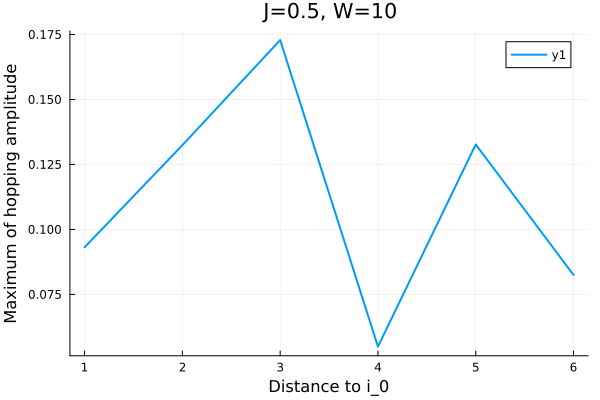

"/Users/jessica/git/Square-Spin-Ice/New code/hopping_amplitude_vs_distance_i_0_W=10,J=0.5.png"

In [205]:
means=[]
for i in the_list
    push!(means,maximum(i))
end
p=plot(1:div(L,2), means, linewidth=2, xlabel="Distance to i_0", ylabel="Maximum of hopping amplitude", title="J="*string(J_mag)*", W="*string(W))

display(p)
savefig(p, "hopping_amplitude_vs_distance_i_0_W="*string(W)*",J="*string(J_mag)*".png")

In [20]:
include("unitTests.jl")
average_hopping_distance_from_i_0_obc(([1,2,100],[5,6,7]), 4)


17.833333333333332

In [68]:
find_possible_pivots_sector([1], [2], the_map)

252-element Vector{Any}:
 (2262, 2263)
 (1954, 1955)
 (2842, 2843)
 (3474, 3475)
 (366, 367)
 (2502, 2503)
 (1086, 1087)
 (2142, 2143)
 (686, 687)
 (1626, 1627)
 (1746, 1747)
 (1118, 1119)
 (486, 487)
 ⋮
 (2914, 2915)
 (2606, 2607)
 (870, 871)
 (462, 463)
 (1818, 1819)
 (1182, 1183)
 (3282, 3283)
 (606, 607)
 (3274, 3275)
 (222, 223)
 (3858, 3859)
 (3226, 3227)

In [307]:
the_states' * get_N_R_operator_eigenstate_basis(L, the_map, eigtemp.vectors, i_0) * the_states

1.143862027726409

In [308]:
the_states' * eigtemp.vectors' * get_N_R_operator(L, the_map, i_0) * eigtemp.vectors * the_states

5.999999999999974

In [235]:
T = 1 # random hopping strength
L=6
W=0
JJ=1
t = T*ones(Float64, L); #hopping
#t = ones(L)
d=Uniform(-1,1)
h = W*rand(d, L); # disordered onsite potentials
J = JJ*ones(Float64, L); # interactions
H,max_index=construct_disordered_interacting_hamiltonian_next_nearest_neighbor(L, J, h, t, true,"full")

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 4.0 0.0; 0.0 0.0 … 0.0 6.0], Vector{Any}[[(2, 3), (6, 7), (10, 11), (14, 15), (18, 19), (22, 23), (26, 27), (30, 31), (34, 35), (38, 39), (42, 43), (46, 47), (50, 51), (54, 55), (58, 59), (62, 63)], [(3, 5), (4, 6), (11, 13), (12, 14), (19, 21), (20, 22), (27, 29), (28, 30), (35, 37), (36, 38), (43, 45), (44, 46), (51, 53), (52, 54), (59, 61), (60, 62)], [(5, 9), (6, 10), (7, 11), (8, 12), (21, 25), (22, 26), (23, 27), (24, 28), (37, 41), (38, 42), (39, 43), (40, 44), (53, 57), (54, 58), (55, 59), (56, 60)], [(9, 17), (10, 18), (11, 19), (12, 20), (13, 21), (14, 22), (15, 23), (16, 24), (41, 49), (42, 50), (43, 51), (44, 52), (45, 53), (46, 54), (47, 55), (48, 56)], [(17, 33), (18, 34), (19, 35), (20, 36), (21, 37), (22, 38), (23, 39), (24, 40), (25, 41), (26, 42), (27, 43), (28, 44), (29, 45), (30, 46), (31, 47), (32, 48)], [(2, 33), (4, 35), (6, 37), (8, 39), (10, 41), (12, 43), (14, 45), (16, 47), (18, 49), (20, 51), (22, 53), (2

In [145]:
T = 1 # random hopping strength
L=4
JJ=1
t = T*ones(Float64, L); #hopping
#t = ones(L)
d=Uniform(-1,1)
h = W*rand(d, L); # disordered onsite potentials
J = JJ*ones(Float64, L); # interactions
#H,max_index=construct_disordered_interacting_hamiltonian_nearest_neighbor(L, J, h, t, false, "full")
H,max_index=construct_disordered_interacting_hamiltonian_next_nearest_neighbor(L, J, h, t, true, "full")

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 2.0 0.0; 0.0 0.0 … 0.0 4.0], Vector{Any}[[(2, 3), (5, 8), (10, 11), (13, 16)], [(3, 5), (4, 6), (9, 15), (10, 16)], [(2, 14), (4, 16), (5, 9), (7, 11)], [(3, 12), (4, 11), (7, 16), (8, 15)]])

In [168]:
H[6,6]

2.0

In [204]:
L= 5; # system size
T = 1 # random hopping strength
t = T*ones(Float64, L); #hopping
#t = ones(L)
W = 3.1; # disorder strength

d=Uniform(-1,1)
h=W*rand(d, L)
J_mag=0
J = J_mag*ones(Float64, L); # interactions
H, max_index=construct_disordered_interacting_hamiltonian_next_nearest_neighbor(L, J, h, t, false, "full");
max_index = max_index[sortperm(t, rev=true)];

eigtemp=eigen(H)
eigenvectors=eigtemp.vectors

N_R_nodiag=get_N_R_operator_eigenstate_basis(L, eigenvectors, div(L, 2))
println(sqrt(maximum(abs,eigen(N_R_nodiag'*N_R_nodiag).values)))
println(sqrt(norm(N_R_nodiag)^2/(2^L)))

1.0524745977440797
0.4961680102804943


In [205]:
the_map=construct_map_of_n_filling_states(L, div(L,2))
H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_next_nearest_neighbor_half_filling(L, J, h, t,the_map, false, "full")
eigtemp=eigen(H_half_filling)

eigtemp=eigen(H_half_filling)
eigenvectors=eigtemp.vectors
println(size(eigenvectors))
N_R_nodiag=get_N_R_operator_eigenstate_basis(L, the_map, eigenvectors, div(L, 2))
println(sqrt(maximum(abs,eigen(N_R_nodiag'*N_R_nodiag).values)))
println(sqrt(norm(N_R_nodiag)^2/(binomial(L, div(L,2)))))

(10, 10)
1.0524745977440086
0.543524823086167


In [229]:
t = T .* (1 .+ (0:L-1) .% 2)

5-element Vector{Int64}:
 1
 2
 1
 2
 1

In [164]:
construct_disordered_interacting_hamiltonian_next_nearest_neighbor_half_filling

LoadError: UndefVarError: `construct_disordered_interacting_hamiltonian_next_nearest_neighbor_half_filling` not defined

In [230]:
Ls=[4,6,8,10,12,14]
Ws=collect(range(start=0, stop=0, step=1))
disorder_realizations=1
T = 1 # random hopping strength
JJ=0.05
norms=[]
norms_frobenius=[]

the_norms=[]

for W in Ws
    println("W="*string(W))
    norms_W=[]
    
    norms_frobenius_W=[]
for L in Ls
    println("L="*string(L))
    disorder_realizations_data_L=[]
    disorder_realizations_data_L_f=[]
    the_map=construct_map_of_n_filling_states(L, div(L,2))

    for i=1:disorder_realizations
        t = T*ones(Float64, L); #hopping

        # alernating hopping
        t = T .* (1 .+ (0:L-1) .% 2)

        #t = ones(L)
        d=Uniform(-1,1)
        h = W*rand(d, L); # disordered onsite potentials
        J = JJ*ones(Float64, L); # interactions
        H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_next_nearest_neighbor_half_filling(L, J, h, t,the_map, false, "full")        
        eigenvalues, eigenvectors=eigen(H_half_filling);
        N_R_nodiag=get_N_R_operator_eigenstate_basis(L, the_map, eigenvectors, div(L, 2))
        norm_M=sqrt(maximum(abs, eigvals(N_R_nodiag*N_R_nodiag')))
        push!(disorder_realizations_data_L,norm_M)
        push!(the_norms, norm_M)
        push!(disorder_realizations_data_L_f,norm(N_R_nodiag))
    end
    push!(norms_W,disorder_realizations_data_L)
    push!(norms_frobenius_W,disorder_realizations_data_L_f)
end
    #save_object("8_4_nonintegrable_M_operator_norm_W="*string(W)*", J="*string(JJ)*", t="*string(T)*".jld2", norms_W)
    #save_object("8_4_nonintegrable_M_frobenius_norm_W="*string(W)*", J="*string(JJ)*", t="*string(T)*".jld2", norms_frobenius_W)

    push!(norms, norms_W)
    push!(norms_frobenius, norms_frobenius_W)
end

W=0
L=4
L=6
L=8
L=10
L=12
L=14


In [231]:
4 .* the_norms

6-element Vector{Float64}:
  4.000000000000002
  6.000000000000006
  8.000000000000002
 10.0
 12.000000000000005
 14.0000000000003

In [232]:
p=plot(Ls,the_norms, linewidth=2, markers=:circle, xticks=(Ls, Ls), ylabel=L"|\!|\hat M|\!|_{\mathrm{op}}",xlabel=L"L",label="",dpi=300)
savefig(p,"nonintegrable_alternating_hopping_free_M.png")

"/Users/jessica/git/Square-Spin-Ice/New code/nonintegrable_alternating_hopping_free_M.png"

In [55]:
L=14
W=10
JJ=0.01
t = T*ones(Float64, L); #hopping
#t = ones(L)
d=Uniform(-1,1)
the_map=construct_map_of_n_filling_states(L, div(L,2))
h = W*rand(d, L); # disordered onsite potentials
J = JJ*ones(Float64, L); # interactions
H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_nearest_neighbor_half_filling(L, J, h, t,the_map, false, "full")        
eigenvalues, eigenvectors=eigen(H_half_filling);
N_R_nodiag=get_N_R_operator_eigenstate_basis(L, the_map, eigenvectors, div(L, 2))

3432×3432 Matrix{Float64}:
  0.0           0.0431035     0.00647092   …  -7.31797e-18  -1.45117e-18
  0.0431035     0.0           0.000834724      1.87852e-16  -3.8775e-17
  0.00647092    0.000834724   0.0             -3.32124e-16  -1.79875e-16
 -0.024015     -0.00366067   -0.00100403       4.21192e-16  -4.13187e-17
 -1.80019e-5    8.42862e-5    5.65659e-5       1.6416e-18    9.64846e-19
  0.00355437    0.000271836  -1.35453e-7   …  -1.65045e-16   7.86988e-16
  6.78494e-5    5.2293e-6    -2.31728e-9      -2.95266e-17   1.46547e-16
 -0.00101595   -2.23169e-7   -0.000271583     -2.09722e-17   8.32361e-17
 -0.000603178  -0.000132708  -3.8799e-5        2.65447e-17   1.15409e-17
  1.96386e-5    6.65361e-9    5.21048e-6       6.62333e-19  -4.13115e-19
  4.92836e-6   -4.26317e-5   -2.01943e-5   …   9.91167e-16   3.36609e-16
  4.8869e-6     3.88779e-7    1.55027e-9      -9.81989e-20   1.00118e-18
  0.00454205    2.9927e-6    -1.38774e-6      -6.3383e-18   -6.31347e-18
  ⋮                      

In [67]:
eigenvectors'*N_R_nodiag*eigenvectors

3432×3432 Matrix{Float64}:
  5.1264e-6    -0.000313365   0.000267452  …  -7.60012e-5   -4.70044e-6
 -0.000313365   0.00623453   -0.00268208      -4.10788e-6    9.92903e-5
  0.000267452  -0.00268208   -0.00296469      -2.48767e-5    3.79429e-6
  2.75852e-6   -0.0038703     0.00787594       9.48059e-7    5.41247e-5
 -5.02436e-6   -1.68263e-5    0.000131105      8.92098e-6   -7.2049e-7
 -8.20004e-5    0.00155193   -0.000655013  …  -2.56576e-5   -0.000391257
 -4.46913e-5    7.18536e-5    6.36554e-5       7.72595e-6   -3.70941e-6
 -5.63557e-5    0.000670641   0.000728194      4.68019e-6    3.01626e-5
  0.00131558   -0.0173415    -0.00614722       3.65611e-6    2.32814e-5
  0.000411169   6.04655e-5   -0.000112515     -3.2855e-5    -1.35384e-6
  3.23413e-6    1.0165e-5     2.54005e-5   …  -7.15776e-6    1.32407e-6
  5.09954e-5   -4.65422e-5    3.84806e-5      -3.78442e-6   -3.23465e-5
  3.8943e-6     0.000937899  -0.00193509       1.39121e-5    0.00021136
  ⋮                                  

In [57]:
norm(N_R_nodiag)


3.9197261831146486

In [66]:
computational_basis_N_R=(eigenvectors'*N_R_nodiag*eigenvectors)

3432×3432 Matrix{Float64}:
  5.1264e-6    -0.000313365   0.000267452  …  -7.60012e-5   -4.70044e-6
 -0.000313365   0.00623453   -0.00268208      -4.10788e-6    9.92903e-5
  0.000267452  -0.00268208   -0.00296469      -2.48767e-5    3.79429e-6
  2.75852e-6   -0.0038703     0.00787594       9.48059e-7    5.41247e-5
 -5.02436e-6   -1.68263e-5    0.000131105      8.92098e-6   -7.2049e-7
 -8.20004e-5    0.00155193   -0.000655013  …  -2.56576e-5   -0.000391257
 -4.46913e-5    7.18536e-5    6.36554e-5       7.72595e-6   -3.70941e-6
 -5.63557e-5    0.000670641   0.000728194      4.68019e-6    3.01626e-5
  0.00131558   -0.0173415    -0.00614722       3.65611e-6    2.32814e-5
  0.000411169   6.04655e-5   -0.000112515     -3.2855e-5    -1.35384e-6
  3.23413e-6    1.0165e-5     2.54005e-5   …  -7.15776e-6    1.32407e-6
  5.09954e-5   -4.65422e-5    3.84806e-5      -3.78442e-6   -3.23465e-5
  3.8943e-6     0.000937899  -0.00193509       1.39121e-5    0.00021136
  ⋮                                  

In [58]:
computational_basis_N_R[1,2]

0.13382570557208998

In [59]:
N_R_nodiag

3432×3432 Matrix{Float64}:
  0.0           0.0431035     0.00647092   …  -7.31797e-18  -1.45117e-18
  0.0431035     0.0           0.000834724      1.87852e-16  -3.8775e-17
  0.00647092    0.000834724   0.0             -3.32124e-16  -1.79875e-16
 -0.024015     -0.00366067   -0.00100403       4.21192e-16  -4.13187e-17
 -1.80019e-5    8.42862e-5    5.65659e-5       1.6416e-18    9.64846e-19
  0.00355437    0.000271836  -1.35453e-7   …  -1.65045e-16   7.86988e-16
  6.78494e-5    5.2293e-6    -2.31728e-9      -2.95266e-17   1.46547e-16
 -0.00101595   -2.23169e-7   -0.000271583     -2.09722e-17   8.32361e-17
 -0.000603178  -0.000132708  -3.8799e-5        2.65447e-17   1.15409e-17
  1.96386e-5    6.65361e-9    5.21048e-6       6.62333e-19  -4.13115e-19
  4.92836e-6   -4.26317e-5   -2.01943e-5   …   9.91167e-16   3.36609e-16
  4.8869e-6     3.88779e-7    1.55027e-9      -9.81989e-20   1.00118e-18
  0.00454205    2.9927e-6    -1.38774e-6      -6.3383e-18   -6.31347e-18
  ⋮                      

In [60]:
get_N_R_operator(L, the_map, div(L, 2))

3432×3432 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [61]:
the_map

Dict{Int64, Int64} with 3432 entries:
  15889 => 30
  8690  => 1635
  9773  => 1373
  8437  => 1693
  1703  => 3202
  3406  => 2818
  2876  => 2948
  11335 => 987
  687   => 3388
  11081 => 1035
  10631 => 1163
  3719  => 2731
  13701 => 434
  12598 => 725
  637   => 3391
  9523  => 1441
  3163  => 2884
  1276  => 3285
  14085 => 357
  3762  => 2714
  10454 => 1212
  9387  => 1479
  15688 => 46
  9956  => 1313
  2746  => 2984
  ⋮     => ⋮

In [47]:
the_map=construct_map_of_n_filling_states(L, div(L,2))


Dict{Int64, Int64} with 3432 entries:
  15889 => 30
  8690  => 1635
  9773  => 1373
  8437  => 1693
  1703  => 3202
  3406  => 2818
  2876  => 2948
  11335 => 987
  687   => 3388
  11081 => 1035
  10631 => 1163
  3719  => 2731
  13701 => 434
  12598 => 725
  637   => 3391
  9523  => 1441
  3163  => 2884
  1276  => 3285
  14085 => 357
  3762  => 2714
  10454 => 1212
  9387  => 1479
  15688 => 46
  9956  => 1313
  2746  => 2984
  ⋮     => ⋮

In [51]:
get_N_R_operator(L, the_map, div(L, 2))

3432×3432 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [50]:
N_R_nodiag=get_N_R_operator_eigenstate_basis(L, the_map, eigenvectors, div(L, 2))

Dict{Int64, Int64} with 3432 entries:
  11279 => 1002
  9676  => 1390
  9923  => 1325
  15889 => 30
  8690  => 1635
  9773  => 1373
  8437  => 1693
  1703  => 3202
  12953 => 624
  10453 => 1213
  1438  => 3259
  3406  => 2818
  699   => 3386
  12716 => 686
  2876  => 2948
  11335 => 987
  687   => 3388
  4978  => 2468
  14930 => 177
  11480 => 938
  13404 => 516
  638   => 3390
  11081 => 1035
  2398  => 3064
  10631 => 1163
  ⋮     => ⋮